In [1]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import norm
#x is duration, y is wait
df = pd.DataFrame({
    'x': [3.6,1.8,2.283,3.333,2.883,4.533,1.95,1.833,4.7,3.6,1.6,4.35,3.917,4.2,1.75,1.8,4.7,2.167,4.8,1.75],
    'y': [79,54,62,74,55,85,51,54,88,85,52,85,84,78,62,51,83,52,84,47]
})

In [8]:
guess = { 'mu1': [1,1],
          'sig1': [ [1, 0], [0, 1] ],
          'mu2': [4,4],
          'sig2': [ [1, 0], [0, 1] ],
          'lambda': [0.4, 0.6]
        }
print(guess)

{'mu1': [1, 1], 'sig1': [[1, 0], [0, 1]], 'mu2': [4, 4], 'sig2': [[1, 0], [0, 1]], 'lambda': [0.4, 0.6]}


In [9]:
# assign every data point to its most likely cluster
def expectation(dataFrame, parameters):
  for i in range(dataFrame.shape[0]):
    x = dataFrame['x'][i]
    y = dataFrame['y'][i]
    p_cluster1 = prob([x, y], list(parameters['mu1']), list(parameters['sig1']), parameters['lambda'][0] )
    p_cluster2 = prob([x, y], list(parameters['mu2']), list(parameters['sig2']), parameters['lambda'][1] )
    if p_cluster1 > p_cluster2:
      dataFrame['label'][i] = 1
    else:
      dataFrame['label'][i] = 2
  return dataFrame

In [10]:
def maximization(dataFrame, parameters):
  points_assigned_to_cluster1 = dataFrame[dataFrame['label'] == 1]
  points_assigned_to_cluster2 = dataFrame[dataFrame['label'] == 2]
  percent_assigned_to_cluster1 = len(points_assigned_to_cluster1) / float(len(dataFrame))
  percent_assigned_to_cluster2 = 1 - percent_assigned_to_cluster1
  parameters['lambda'] = [percent_assigned_to_cluster1, percent_assigned_to_cluster2 ]
  parameters['mu1'] = [points_assigned_to_cluster1['x'].mean(), points_assigned_to_cluster1['y'].mean()]
  parameters['mu2'] = [points_assigned_to_cluster2['x'].mean(), points_assigned_to_cluster2['y'].mean()]
  parameters['sig1'] = [ [points_assigned_to_cluster1['x'].std(), 0 ], [ 0, points_assigned_to_cluster1['y'].std() ] ]
  parameters['sig2'] = [ [points_assigned_to_cluster2['x'].std(), 0 ], [ 0, points_assigned_to_cluster2['y'].std() ] ]
  return parameters

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


iteration 1, shift nan


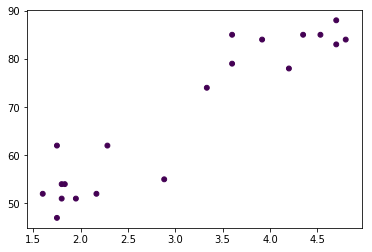

In [11]:
# probability that a point came from a Guassian with given parameters
# note that the covariance must be diagonal for this to work
def prob(val, mu, sig, lam):
  p = lam
  for i in range(len(val)):
    p *= norm.pdf(val[i], mu[i], sig[i][i])
  return p

# get the distance between points
# used for determining if params have converged
def distance(old_params, new_params):
  dist = 0
  for param in ['mu1', 'mu2']:
    for i in range(len(old_params)):
      dist += (old_params[param][i] - new_params[param][i]) ** 2
  return dist ** 0.5
from sys import maxsize
# loop until parameters converge
shift = maxsize
epsilon = 0.01
iters = 0
df_copy = df.copy()
# randomly assign points to their initial clusters
df_copy['label'] = map(lambda x: x+1, np.random.choice(2, len(df)))
params = pd.DataFrame(guess)

colmap = {1: 'r', 2: 'b', 3: 'y'}

while shift > epsilon:
  iters += 1
  # E-step
  updated_labels = expectation(df_copy.copy(), params)

  # M-step
  updated_parameters = maximization(updated_labels, params.copy())

  # see if our estimates of mu have changed
  # could incorporate all params, or overall log-likelihood
  shift = distance(params, updated_parameters)

  # logging
  print("iteration {}, shift {}".format(iters, shift))

  # update labels and params for the next iteration
  df_copy = updated_labels
  params = updated_parameters

  fig = plt.figure()
  plt.scatter(df_copy['x'], df_copy['y'], 24, c=df_copy['label'])
  plt.show()  